In [36]:
#Load libraries
#https://www.learnpytorch.io/04_pytorch_custom_datasets/#6-other-forms-of-transforms-data-augmentation

import os
import torch
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import glob
import random
from PIL import Image
import matplotlib.pyplot as plt


from torchvision import datasets, transforms
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Testing_Accuracy_food-101')
import gc
from collections import defaultdict
from shutil import copy


In [3]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

--2022-08-13 22:42:45--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2022-08-13 22:42:46--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  13.0MB/s    in 5m 50s  

2022-08-13 22:48:37 (13.6 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]



In [ ]:
!tar -xvzf food-101.tar.gz

In [6]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')

In [ ]:
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

In [9]:

#Path for training and testing directory
train_path= r'train'
test_path= r'test'

In [10]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)
print(len(classes))

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

Random image path: train/croque_madame/3699025.jpg
Image height: 512
Image width: 512


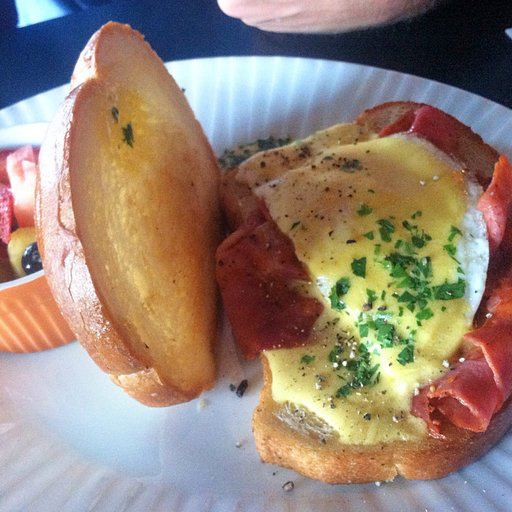

In [11]:
# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all train image paths 
image_path_list = list(glob.glob(train_path+'/**/*.jpg'))
# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
#image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
#print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

In [12]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

Data Augmentations

In [13]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

In [14]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            #fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


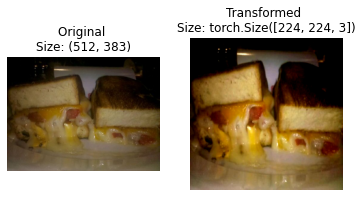

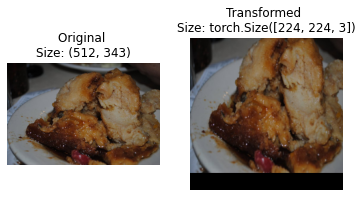

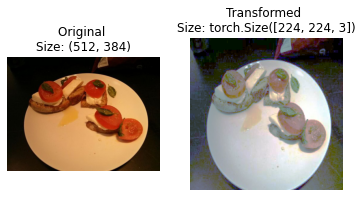

In [16]:
# Get all image paths
image_path_list = list(glob.glob(train_path+'/**/*.jpg'))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

In [17]:
#Dataloader

#Path for training and testing directory
train_path= r'train'
test_path= r'test'

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=train_transforms),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=test_transforms),
    batch_size=32, shuffle=True
)

In [18]:
class AllConvNet(torch.nn.Module):

    def __init__(self, num_classes):
        super().__init__()
        
        self.net = torch.nn.Sequential(
                      torch.nn.Conv2d(in_channels=3,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1,
                                      bias=False),
                      torch.nn.BatchNorm2d(16),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.Conv2d(in_channels=16,
                                      out_channels=16,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1,
                                      bias=False),   
                      torch.nn.BatchNorm2d(16),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.Conv2d(in_channels=16,
                                      out_channels=32,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1,
                                      bias=False),        
                      torch.nn.BatchNorm2d(32),
                      torch.nn.ReLU(inplace=True),                        
                      torch.nn.Conv2d(in_channels=32,
                                      out_channels=32,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1,
                                      bias=False),      
                      torch.nn.BatchNorm2d(32),
                      torch.nn.ReLU(inplace=True),       
                      torch.nn.Conv2d(in_channels=32,
                                      out_channels=64,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1,
                                      bias=False),   
                      torch.nn.BatchNorm2d(64),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.Conv2d(in_channels=64,
                                      out_channels=64,
                                      kernel_size=(3, 3),
                                      stride=(2, 2),
                                      padding=1,
                                      bias=False),     
                      torch.nn.BatchNorm2d(64),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.Conv2d(in_channels=64,
                                      out_channels=num_classes,
                                      kernel_size=(3, 3),
                                      stride=(1, 1),
                                      padding=1,
                                      bias=False),    
                      torch.nn.BatchNorm2d(101),
                      torch.nn.ReLU(inplace=True),
                      torch.nn.AdaptiveAvgPool2d(1),
                      torch.nn.Flatten()
    )


    def forward(self, x):
        
        x = self.net(x)
        #probas = torch.softmax(x, dim=1)
        return x

In [19]:
model=AllConvNet(num_classes=101).to(device)

In [20]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [37]:
num_epochs=10
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [38]:
print(train_count,test_count)
print(num_epochs)


75750 25250
10


In [39]:
from tqdm import tqdm

In [ ]:
#Model training and saving best model

best_accuracy=0.0

for epoch in tqdm(range(0,num_epochs)):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i, (images,labels) in tqdm(enumerate(train_loader)):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in tqdm(enumerate(test_loader)):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
    
    test_accuracy=test_accuracy/test_count
    
  
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    

# default `log_dir` is "runs" - we'll be more specific here
    writer.add_scalar('Training Accuracy',
                            test_accuracy,
                            epoch)
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy
    
       

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  1.59it/s]
2it [00:01,  1.59it/s]
3it [00:01,  1.60it/s]
4it [00:02,  1.59it/s]
5it [00:03,  1.61it/s]
6it [00:03,  1.63it/s]
7it [00:04,  1.64it/s]
8it [00:04,  1.65it/s]
9it [00:05,  1.67it/s]
10it [00:06,  1.70it/s]
11it [00:06,  1.71it/s]
12it [00:07,  1.72it/s]
13it [00:07,  1.71it/s]
14it [00:08,  1.71it/s]
15it [00:09,  1.69it/s]
16it [00:09,  1.51it/s]
17it [00:10,  1.39it/s]
18it [00:11,  1.38it/s]
19it [00:12,  1.47it/s]
20it [00:12,  1.53it/s]
21it [00:13,  1.59it/s]
22it [00:13,  1.62it/s]
23it [00:14,  1.64it/s]
24it [00:14,  1.64it/s]
25it [00:15,  1.63it/s]
26it [00:16,  1.62it/s]
27it [00:16,  1.61it/s]
28it [00:17,  1.65it/s]
29it [00:18,  1.65it/s]
30it [00:18,  1.67it/s]
31it [00:19,  1.68it/s]
32it [00:19,  1.68it/s]
33it [00:20,  1.70it/s]
34it [00:20,  1.68it/s]
35it [00:21,  1.69it/s]
36it [00:22,  1.69it/s]
37it [00:22,  1.68it/s]
38it [00:23,  1.71it/s]
39it [00:23,  1.71it/s]
40it [00:24,  1

Epoch: 0 Train Loss: tensor(3.9854) Train Accuracy: 0.1375181518151815 Test Accuracy: 0.16015841584158416



0it [00:00, ?it/s]
1it [00:00,  1.66it/s]
2it [00:01,  1.63it/s]
3it [00:01,  1.66it/s]
4it [00:02,  1.66it/s]
5it [00:03,  1.66it/s]
6it [00:03,  1.65it/s]
7it [00:04,  1.65it/s]
8it [00:04,  1.66it/s]
9it [00:05,  1.65it/s]
10it [00:06,  1.66it/s]
11it [00:06,  1.69it/s]
12it [00:07,  1.68it/s]
13it [00:07,  1.68it/s]
14it [00:08,  1.68it/s]
15it [00:08,  1.71it/s]
16it [00:09,  1.75it/s]
17it [00:10,  1.77it/s]
18it [00:10,  1.77it/s]
19it [00:11,  1.77it/s]
20it [00:11,  1.78it/s]
21it [00:12,  1.78it/s]
22it [00:12,  1.78it/s]
23it [00:13,  1.78it/s]
24it [00:13,  1.78it/s]
25it [00:14,  1.78it/s]
26it [00:15,  1.78it/s]
27it [00:15,  1.79it/s]
28it [00:16,  1.79it/s]
29it [00:16,  1.78it/s]
30it [00:17,  1.78it/s]
31it [00:17,  1.79it/s]
32it [00:18,  1.79it/s]
33it [00:19,  1.79it/s]
34it [00:19,  1.80it/s]
35it [00:20,  1.80it/s]
36it [00:20,  1.80it/s]
37it [00:21,  1.80it/s]
38it [00:21,  1.81it/s]
39it [00:22,  1.78it/s]
40it [00:22,  1.79it/s]
41it [00:23,  1.78it/s]
42it 

Epoch: 1 Train Loss: tensor(3.7926) Train Accuracy: 0.17566996699669968 Test Accuracy: 0.21465346534653465



0it [00:00, ?it/s]
1it [00:00,  1.65it/s]
2it [00:01,  1.74it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.75it/s]
5it [00:02,  1.79it/s]
6it [00:03,  1.80it/s]
7it [00:03,  1.81it/s]
8it [00:04,  1.82it/s]
9it [00:05,  1.81it/s]
10it [00:05,  1.81it/s]
11it [00:06,  1.80it/s]
12it [00:06,  1.82it/s]
13it [00:07,  1.80it/s]
14it [00:07,  1.82it/s]
15it [00:08,  1.80it/s]
16it [00:08,  1.79it/s]
17it [00:09,  1.80it/s]
18it [00:10,  1.80it/s]
19it [00:10,  1.80it/s]
20it [00:11,  1.81it/s]
21it [00:11,  1.83it/s]
22it [00:12,  1.83it/s]
23it [00:12,  1.83it/s]
24it [00:13,  1.82it/s]
25it [00:13,  1.81it/s]
26it [00:14,  1.80it/s]
27it [00:14,  1.81it/s]
28it [00:15,  1.80it/s]
29it [00:16,  1.80it/s]
30it [00:16,  1.79it/s]
31it [00:17,  1.80it/s]
32it [00:17,  1.79it/s]
33it [00:18,  1.80it/s]
34it [00:18,  1.80it/s]
35it [00:19,  1.82it/s]
36it [00:19,  1.83it/s]
37it [00:20,  1.82it/s]
38it [00:21,  1.81it/s]
39it [00:21,  1.82it/s]
40it [00:22,  1.83it/s]
41it [00:22,  1.82it/s]
42it 

Epoch: 2 Train Loss: tensor(3.6327) Train Accuracy: 0.20864686468646865 Test Accuracy: 0.276950495049505



0it [00:00, ?it/s]
1it [00:00,  1.66it/s]
2it [00:01,  1.73it/s]
3it [00:01,  1.71it/s]
4it [00:02,  1.75it/s]
5it [00:02,  1.75it/s]
6it [00:03,  1.78it/s]
7it [00:03,  1.79it/s]
8it [00:04,  1.82it/s]
9it [00:05,  1.84it/s]
10it [00:05,  1.84it/s]
11it [00:06,  1.83it/s]
12it [00:06,  1.83it/s]
13it [00:07,  1.83it/s]
14it [00:07,  1.82it/s]
15it [00:08,  1.83it/s]
16it [00:08,  1.84it/s]
17it [00:09,  1.82it/s]
18it [00:09,  1.82it/s]
19it [00:10,  1.81it/s]
20it [00:11,  1.81it/s]
21it [00:11,  1.81it/s]
22it [00:12,  1.82it/s]
23it [00:12,  1.81it/s]
24it [00:13,  1.82it/s]
25it [00:13,  1.81it/s]
26it [00:14,  1.83it/s]
27it [00:14,  1.82it/s]
28it [00:15,  1.82it/s]
29it [00:16,  1.81it/s]
30it [00:16,  1.82it/s]
31it [00:17,  1.82it/s]
32it [00:17,  1.82it/s]
33it [00:18,  1.82it/s]
34it [00:18,  1.82it/s]
35it [00:19,  1.83it/s]
36it [00:19,  1.81it/s]
37it [00:20,  1.81it/s]
38it [00:20,  1.80it/s]
39it [00:21,  1.81it/s]
40it [00:22,  1.80it/s]
41it [00:22,  1.81it/s]
42it 

Epoch: 3 Train Loss: tensor(3.5003) Train Accuracy: 0.23421782178217823 Test Accuracy: 0.24055445544554455



0it [00:00, ?it/s]
1it [00:00,  1.67it/s]
2it [00:01,  1.73it/s]
3it [00:01,  1.74it/s]
4it [00:02,  1.78it/s]
5it [00:02,  1.79it/s]
6it [00:03,  1.79it/s]
7it [00:03,  1.80it/s]
8it [00:04,  1.79it/s]
9it [00:05,  1.78it/s]
10it [00:05,  1.80it/s]
11it [00:06,  1.79it/s]
12it [00:06,  1.79it/s]
13it [00:07,  1.80it/s]
14it [00:07,  1.82it/s]
15it [00:08,  1.81it/s]
16it [00:08,  1.80it/s]
17it [00:09,  1.79it/s]
18it [00:10,  1.78it/s]
19it [00:10,  1.79it/s]
20it [00:11,  1.79it/s]
21it [00:11,  1.81it/s]
22it [00:12,  1.82it/s]
23it [00:12,  1.83it/s]
24it [00:13,  1.83it/s]
25it [00:13,  1.83it/s]
26it [00:14,  1.82it/s]
27it [00:15,  1.81it/s]
28it [00:15,  1.82it/s]
29it [00:16,  1.82it/s]
30it [00:16,  1.81it/s]
31it [00:17,  1.82it/s]
32it [00:17,  1.82it/s]
33it [00:18,  1.83it/s]
34it [00:18,  1.82it/s]
35it [00:19,  1.81it/s]
36it [00:19,  1.82it/s]
37it [00:20,  1.80it/s]
38it [00:21,  1.81it/s]
39it [00:21,  1.80it/s]
40it [00:22,  1.80it/s]
41it [00:22,  1.81it/s]
42it 

Epoch: 4 Train Loss: tensor(3.3909) Train Accuracy: 0.25354455445544555 Test Accuracy: 0.2955247524752475



0it [00:00, ?it/s]
1it [00:00,  1.72it/s]
2it [00:01,  1.74it/s]
3it [00:01,  1.77it/s]
4it [00:02,  1.79it/s]
5it [00:02,  1.81it/s]
6it [00:03,  1.83it/s]
7it [00:03,  1.82it/s]
8it [00:04,  1.83it/s]
9it [00:04,  1.83it/s]
10it [00:05,  1.81it/s]
11it [00:06,  1.82it/s]
12it [00:06,  1.83it/s]
13it [00:07,  1.83it/s]
14it [00:07,  1.84it/s]
15it [00:08,  1.83it/s]
16it [00:08,  1.82it/s]
17it [00:09,  1.81it/s]
18it [00:09,  1.82it/s]
19it [00:10,  1.82it/s]
20it [00:11,  1.81it/s]
21it [00:11,  1.82it/s]
22it [00:12,  1.81it/s]
23it [00:12,  1.79it/s]
24it [00:13,  1.79it/s]
25it [00:13,  1.79it/s]
26it [00:14,  1.81it/s]
27it [00:14,  1.80it/s]
28it [00:15,  1.78it/s]
29it [00:16,  1.80it/s]
30it [00:16,  1.79it/s]
31it [00:17,  1.80it/s]
32it [00:17,  1.80it/s]
33it [00:18,  1.79it/s]
34it [00:18,  1.80it/s]
35it [00:19,  1.80it/s]
36it [00:19,  1.81it/s]
37it [00:20,  1.82it/s]
38it [00:21,  1.83it/s]
39it [00:21,  1.81it/s]
40it [00:22,  1.82it/s]
41it [00:22,  1.81it/s]
42it 

Epoch: 5 Train Loss: tensor(3.2917) Train Accuracy: 0.27456105610561055 Test Accuracy: 0.3024950495049505



0it [00:00, ?it/s]
1it [00:00,  1.68it/s]
2it [00:01,  1.75it/s]
3it [00:01,  1.78it/s]
4it [00:02,  1.78it/s]
5it [00:02,  1.80it/s]
6it [00:03,  1.80it/s]
7it [00:03,  1.82it/s]
8it [00:04,  1.82it/s]
9it [00:04,  1.83it/s]
10it [00:05,  1.83it/s]
11it [00:06,  1.83it/s]
12it [00:06,  1.83it/s]
13it [00:07,  1.83it/s]
14it [00:07,  1.82it/s]
15it [00:08,  1.79it/s]
16it [00:08,  1.80it/s]
17it [00:09,  1.80it/s]
18it [00:09,  1.82it/s]
19it [00:10,  1.82it/s]
20it [00:11,  1.83it/s]
21it [00:11,  1.82it/s]
22it [00:12,  1.83it/s]
23it [00:12,  1.83it/s]
24it [00:13,  1.83it/s]
25it [00:13,  1.84it/s]
26it [00:14,  1.84it/s]
27it [00:14,  1.83it/s]
28it [00:15,  1.83it/s]
29it [00:15,  1.82it/s]
30it [00:16,  1.83it/s]
31it [00:17,  1.83it/s]
32it [00:17,  1.82it/s]
33it [00:18,  1.82it/s]
34it [00:18,  1.82it/s]
35it [00:19,  1.84it/s]
36it [00:19,  1.82it/s]
37it [00:20,  1.81it/s]
38it [00:20,  1.80it/s]
39it [00:21,  1.82it/s]
40it [00:22,  1.83it/s]
41it [00:22,  1.82it/s]
42it 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!tensorboard dev upload --logdir runs --name "My First Deep learning experiment" --description "Training the Food-101 datasets" 


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

runs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 